<a href="https://colab.research.google.com/github/kxk302/MBA/blob/new_data/MBA_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/MyDrive/Colab Notebooks/'

Antecedents_2.png  Consequent_2.png  HIV	    MBA_new_data.ipynb
Antecedents_3.png  Consequent_3.png  hiv_rules.csv
Antecedents_4.png  Consequent_4.png  MBA.ipynb


In [69]:
import itertools
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from operator import itemgetter

import numpy as np
import pandas as pd

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

af_dict = {
  "1":"AF < 0.20",
  "2": "0.80 > AF >= 0.20",
  "3":"AF >= 0.80"
}

effect_dict = {
  "1": "NON_SYNONYMOUS_CODING",
  "2": "SYNONYMOUS_CODING",
  "3": "CODON_CHANGE_PLUS_CODON_DELETION",
  "4": "CODON_DELETION",
  "5": "STOP_GAINED",
  "6": "FRAME_SHIFT"
}

# To get the dataframe row index inside apply()
def rowIndex(row):
  return row.name

def to_lst_each(items):
  items_lst = []
  for item in items:
    # Label = EFFECT + AF + POS
    item_lst = [ int(str(item)[2:]), int(str(item)[0]), int(str(item)[1]) ]
    items_lst.append(item_lst)
  return items_lst

# Convert series of antecedents/consequents to a list of [position, effect, af]  
def to_list(ser):
  # Convert forzenset to list
  ser = ser.apply(lambda x: list(x))

  # Convert list elements from string to int
  ser = ser.apply(convert_str_list_to_int_list)
  
  return ser.apply(to_lst_each)

def to_str_each(items):
  items_str = ""
  for item in items:
    # Label = EFFECT + AF + POS
    item_str = "(" + effect_dict.get(str(item)[0]) + ", " + af_dict.get(str(item)[1]) + ", " + str(item)[2:] + ") & "
    items_str += item_str
  return items_str[:-3]

def convert_str_list_to_int_list(str_list):
  return [int(elem) for elem in str_list]

# Convert series of antecedents/consequents to human readable 
def to_str(ser):    
  # Convert forzenset to list
  ser = ser.apply(lambda x: list(x))

  # Convert list elements from string to int
  ser = ser.apply(convert_str_list_to_int_list)

  return ser.apply(to_str_each)

def add_readable_rules(df_in):
  # Empty data frame
  if df_in is None or df_in.shape[0] == 0:
    return df_in

  df = df_in.copy()

  antecedents_str = to_str(df['antecedents'])
  consequents_str = to_str(df['consequents'])

  antecedents_lst = to_list(df['antecedents'])
  consequents_lst = to_list(df['consequents'])

  readable_rule = "(" + antecedents_str + ") => (" + consequents_str + ")"
  df.insert(2,'readable_rule', readable_rule)
  df.insert(2, 'consequents_lst', consequents_lst)
  df.insert(2, 'antecedents_lst', antecedents_lst)

  return df

def filter_on_position_probability(df_in, start_prob=None, end_prob=None):
    if df_in is None or df_in.shape[0] == 0:
      return df_in

    if start_prob is None and end_prob is None:
      return df_in

    # Only consider rows where probability of Position being present in the Samples is >= start_prob and <= end_prob
    num_samples = df_in['Sample'].nunique()
    print("num_samples: {}".format(num_samples))

    num_positions = df_in['POS'].nunique()
    print("num_positions: {}".format(num_positions))
   
    df = df_in[['Sample', 'POS']].groupby(['POS']).agg(position_prob=('Sample', 'count'))
    # Normalize position_prob by dividing it by num_samples. This makes it a proability between 0.0 and 1.0
    df['position_prob'] = df['position_prob'] / num_samples   

    df_sorted = df.sort_values(by = 'position_prob')
    print(df_sorted.head())
    print(df_sorted.tail())
  
    if start_prob is not None:
      df = df[df.position_prob >= start_prob]

    if end_prob is not None:
      df = df[df.position_prob <= end_prob]
    
    ret_val = pd.merge(df_in, df, on='POS')

    df_sorted = ret_val.sort_values(by = 'position_prob')[['POS', 'position_prob']]
    print(df_sorted.head())
    print(df_sorted.tail())

    return ret_val

def get_position_probability(df_in, position=None):
    if df_in is None or df_in.shape[0] == 0:
      return df_in

    if position is None:
      return df_in

    num_samples = df_in['Sample'].nunique()
    print("num_samples: {}".format(num_samples))

    num_positions = df_in['POS'].nunique()
    print("num_positions: {}".format(num_positions))
   
    df = df_in[['Sample', 'POS']].groupby(['POS']).agg(position_prob=('Sample', 'count'))
    # Normalize position_prob by dividing it by num_samples. This makes it a proability between 0.0 and 1.0
    df['position_prob'] = df['position_prob'] / num_samples

    try:      
      return df.loc[position,'position_prob']
    except KeyError:
      return -1

def filter_on_column_values(df_in, start_pos=None, end_pos=None, start_af=None, end_af=None, effect=[]):  
  if df_in is None or df_in.shape[0] == 0:
    return df_in

  df = df_in.copy()

  # Replace "." with "NONE" in FUNCLASS column. They both represent "Non-coding" variant
  df["EFFECT"] = df["EFFECT"].replace('.', 'NONE')

  # Filter in_file rows
  if start_pos is not None:
    df = df[df.POS >= start_pos]    
  if end_pos is not None:
    df = df[df.POS < end_pos]    
  if start_af is not None:
    df = df[df.AF >= start_af]    
  if end_af is not None:
    df = df[df.AF < end_af]    
  if len(effect) > 0:    
    df = df[df.EFFECT.isin(effect)]

  return df

# Create a single integer representing a variant at a specific position with a specific allele frequency
# Pivot the data so we have all sample variants on a single line
#
# Extract rows from in_file where
# 
#    POS >= start_pos & POS <= end_pos
#        If start_pos = None: POS <= end_pos
#        If end_pos = None: POS >= start_pos 
#
#    AF >= start_af & AF <= end_af
#        If start_af = None: AF <= end_af
#        If end_af = None: AF >= start_af
#
#    EFFECT in effect (effect is a dict)      
#
def preprocess_input_file(df_in, effect):
  if df_in is None or df_in.shape[0] == 0:
    return df_in
  
  df = df_in.copy()

  # Bucket values in EFFECT and AF columns. We do not bucket the values in POS column.

  # Replace variants in EFFECT column with a distinct numeric value
  for key, value in effect.items():
    df.loc[df.EFFECT == key, "EFFECT"] = value 
  
  # Replace allele frequency in AF column with a distict numeric value
  df.loc[df.AF >= 0.80, "AF"] = 3
  df.loc[(df.AF >= 0.20) & (df.AF < 0.80), "AF"] = 2
  df.loc[df.AF < 0.20, "AF"] = 1

  # Convert AF values to integer
  df = df.astype({"AF": int}) 

  # Get the largest position value
  max_pos = df["POS"].max()
  # Get the length of max_pos string
  max_pos_len = len(str(max_pos))

  # Create a new column called 'Label', which is a string concatentation of POS, EFFECT, and AF values. 
  # The idea is to represent each variant + allele frequency + position as a single integer, to be used in MBA 
  # zero fill position, so all labels have the same length
  df["POS"].apply(lambda x: str(x).zfill(max_pos_len))
  df["Label"] = + df["EFFECT"].astype(str) + df["AF"].astype(str) + df["POS"].astype(str)

  # We do not need POS, EFFECT, and AF columns anymore
  df = df[["Sample", "Label"]]
  
  # Add a new column called 'Value', prepopulated with 1
  df["Value"] = 1

  df = pd.pivot_table(df, index="Sample", columns="Label", values="Value")

  # Set all data frame nan (not a number) values to 0
  df = df.fillna(0)

  # Convert all data framevalues to integer
  df = df.astype(int) 

  return df

In [70]:
def get_association_rules(in_file, min_support=0.20, min_confidence=0.80, min_lift=1.0, min_conviction=1.0, max_len=None, start_pos=None, end_pos=None, start_af=None, end_af=None, effect={}, start_prob=None, end_prob=None):
  # Read the input file and pick the needed columns
  df_in = pd.read_csv(in_file, sep='\t', encoding='ISO-8859–1')[['Sample', 'POS', 'AF', 'EFFECT']]

  # Filter on position probability
  df_pp = filter_on_position_probability(df_in, start_prob, end_prob)

  # Filter on column values
  df_cv = filter_on_column_values(df_pp, start_pos, end_pos, start_af, end_af, effect.keys())

  # Preprocess the data frame
  df = preprocess_input_file(df_cv, effect)

  # Get frequent item sets, with support larger than min_support, using Apriori algorithm
  frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=max_len)

  # Get association rules, with lift larger than min_lift  
  rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

  # Filter association rules, keeping rules with confidence larger than min_confidence
  rules = rules[ (rules['confidence'] >= min_confidence) & (rules['conviction'] >= min_conviction) ]

  return rules




Number of rules: 145
Dataset association rules: 



     antecedents_lst  consequents_lst  rowIndex       antecedents_idx       consequents_idx  antecedents_len  consequents_len
0    [[21618, 1, 3]]  [[15451, 1, 3]]         0    [[0, 21618, 1, 3]]    [[0, 15451, 1, 3]]                1                1
1    [[25469, 1, 3]]  [[28247, 4, 3]]         1    [[1, 25469, 1, 3]]    [[1, 28247, 4, 3]]                1                1
2    [[25469, 1, 3]]  [[15451, 1, 3]]         2    [[2, 25469, 1, 3]]    [[2, 15451, 1, 3]]                1                1
3    [[22028, 3, 3]]  [[28247, 4, 3]]         3    [[3, 22028, 3, 3]]    [[3, 28247, 4, 3]]                1                1
4    [[21618, 1, 3]]  [[28247, 4, 3]]         4    [[4, 21618, 1, 3]]    [[4, 28247, 4, 3]]                1                1
..               ...              ...       ...                   ...                   ...              ...              ...
140  [[26767, 1, 3]]  [[29402, 1, 3]]       140  [[140, 26767, 

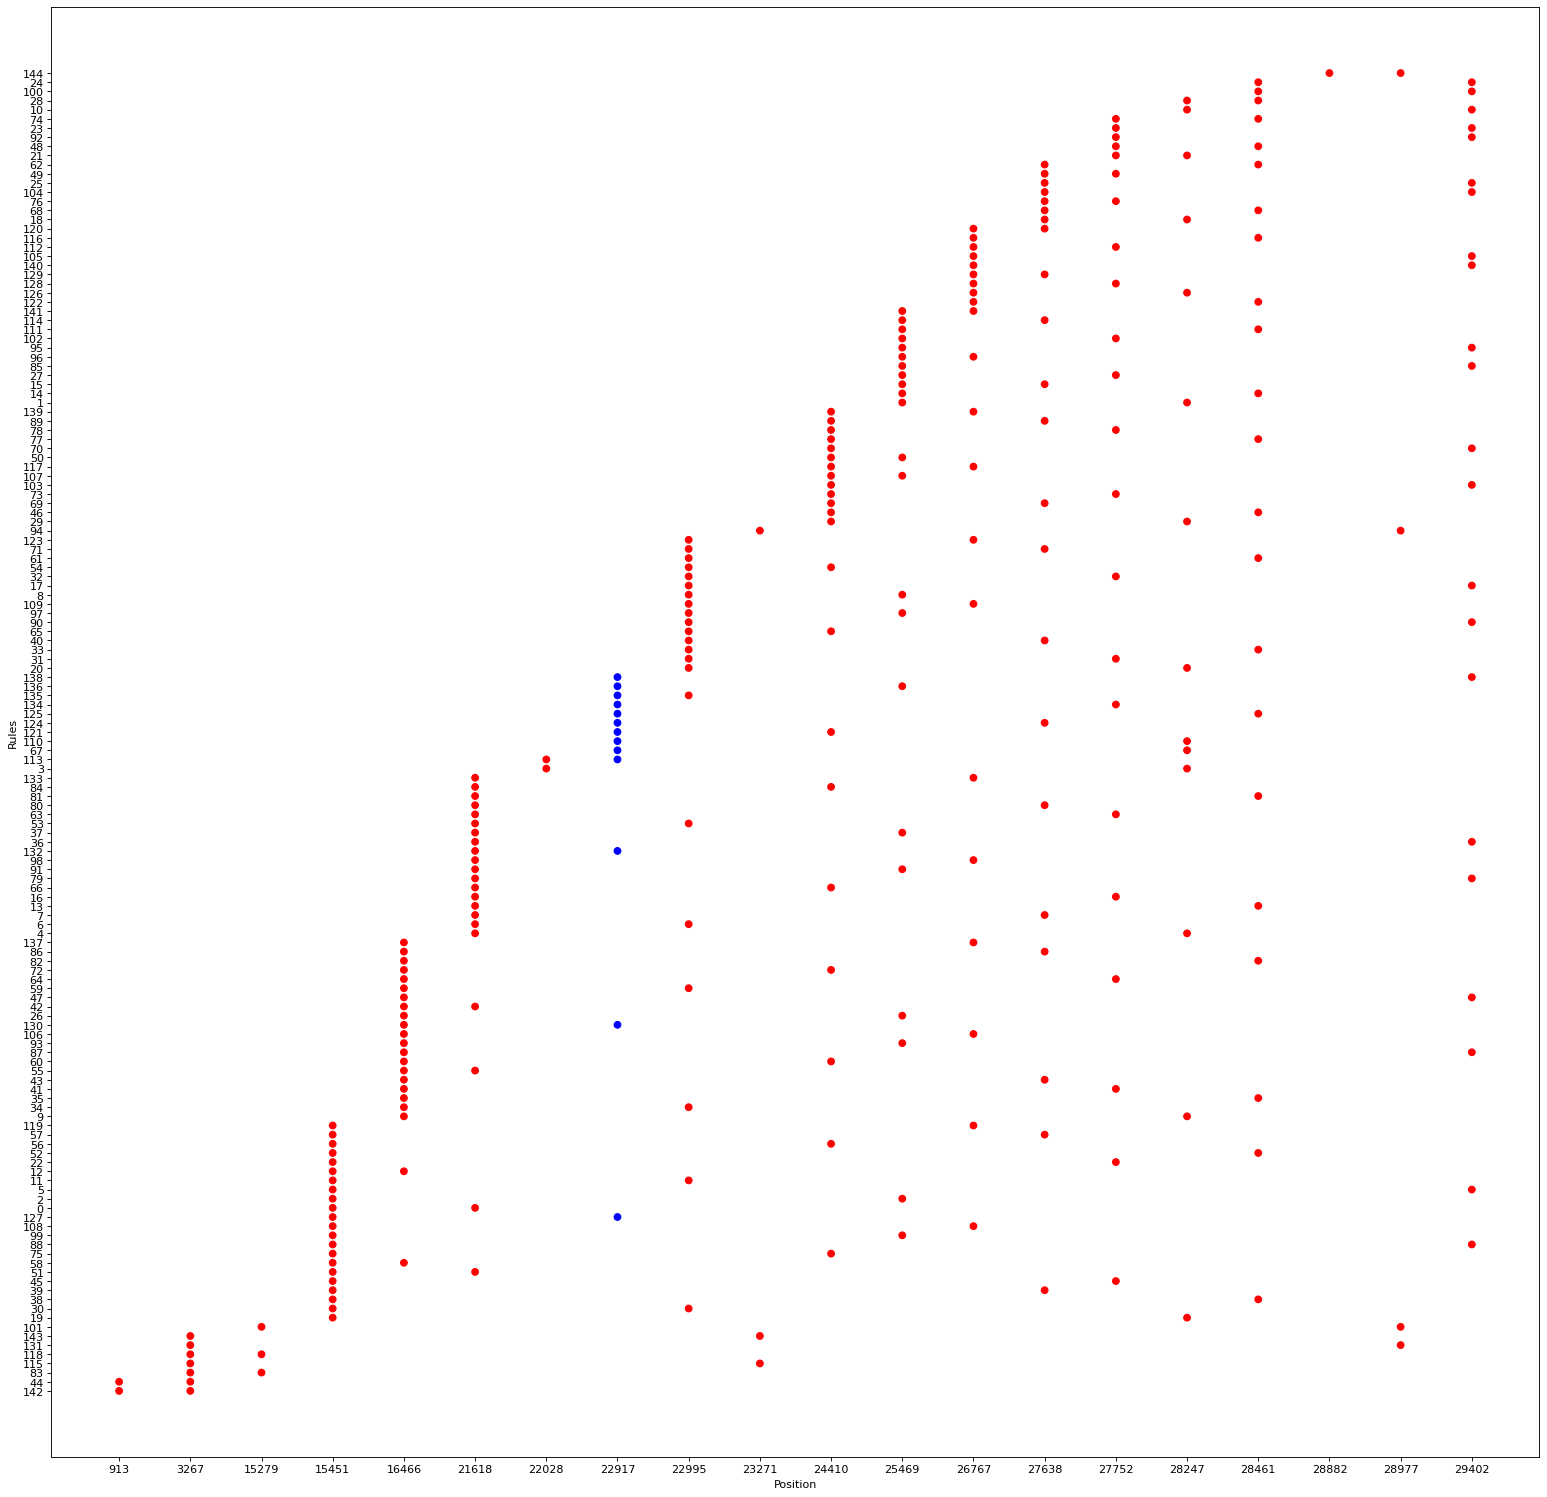

In [72]:
pd.set_option('max_columns', 12, 'display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

effect = {
    "NON_SYNONYMOUS_CODING": 1, 
    "SYNONYMOUS_CODING": 2,
    "CODON_CHANGE_PLUS_CODON_DELETION": 3,
    "CODON_DELETION": 4,
    "STOP_GAINED": 5,
    "FRAME_SHIFT": 6
}

def append_row_index_to_antecedents_lst(row):
  ret_val = []
  for x in row.antecedents_lst:
    row_index_list = [row.rowIndex]
    ret_val.append(row_index_list + x)
  return ret_val

def append_row_index_to_consequents_lst(row):
  ret_val = []
  for x in row.consequents_lst:
    row_index_list = [row.rowIndex]
    ret_val.append(row_index_list + x)
  return ret_val
  
rules = get_association_rules(in_file="https://github.com/kxk302/MBA/raw/new_data/data/gx-observable_data_PRJEB44141_decomp.tsv",
                              min_support=0.20, 
                              min_confidence=0.90, 
                              min_lift=2.00, 
                              min_conviction=2.00, 
                              max_len=2, 
                              effect=effect)

num_rules = rules.shape[0]
print('\n\n')
print('Number of rules: {}'.format(num_rules))
print('Dataset association rules: ')
rules = add_readable_rules(rules)
rules.sort_values(by=["conviction"], ascending=False, inplace=True)
rules.reset_index(inplace=True, drop=True)

rules = rules[['antecedents_lst', 'consequents_lst']]
rules['rowIndex'] = rules.apply(rowIndex, axis=1)
rules['antecedents_idx'] = rules.apply(append_row_index_to_antecedents_lst, axis=1)
rules['consequents_idx'] = rules.apply(append_row_index_to_consequents_lst, axis=1)
rules['antecedents_len'] = rules['antecedents_lst'].apply(lambda x: len(x))
rules['consequents_len'] = rules['consequents_lst'].apply(lambda x: len(x))
print('\n\n')
print(rules.head(num_rules))

ant_lst = rules.antecedents_idx.to_list()
ant_lst = list(itertools.chain(*ant_lst))
print('\n\n')
print("ant_lst length: {}".format(len(ant_lst)))
print(rules.antecedents_len.sum())
print(ant_lst)

con_lst = rules.consequents_idx.to_list()
con_lst = list(itertools.chain(*con_lst))
print('\n\n')
print("con_lst length: {}".format(len(con_lst)))
print(rules.consequents_len.sum())
print(con_lst)

ant_con_list = ant_lst + con_lst
print('\n\n')
print("ant_con_list length: {}".format(len(ant_con_list)))
print(ant_con_list)

ant_con_color_list = []
for item in ant_con_list:
  if item[3] == 3:
    ant_con_color_list.append(item + ['red'])
  elif item[3] == 2:
    ant_con_color_list.append(item + ['blue'])    
  elif item[3] == 1:
    ant_con_color_list.append(item + ['green'])    

print('\n\n')
print("ant_con_color_list length: {}".format(len(ant_con_color_list)))
print(ant_con_color_list)

figure(figsize=(24, 24), dpi=80)
ant_con_color_list_sorted = sorted(ant_con_color_list, key=itemgetter(1))
data = np.array(ant_con_color_list_sorted)
colors = ['red','red','red','blue','red','blue']
plt.title("")
plt.xlabel("Position")
plt.ylabel("Rules")
plt.scatter(data[:,1], data[:,0], marker='o', c = data[:,4])
plt.show()


**Columns in gx-observable_data_PRJEB44141_decomp.tsv.gz (118593 rows including header)**

Sample: Sample ID \\
POS: Position \\
REF: Reference allele. Base that's found in the SARS-CoV-2 reference genome from NCBI \\
ALT: Alternate allele. Something other than REF \\
EFFECT: Type of variation (See text box below) \\
CODON: Triplet changes \\
TRID: Transcript identifier. The name of the gene product that is affected by the variant \\
AA: Amino acid \\
AF: Allele frequency. At the variant site what fraction of spanning reads supports the ALT allele \\

**EFFECT possible values (22 in total)**

. What is dot? \\

**CODON_CHANGE_PLUS_CODON_DELETION**  \\
E.g., GAGTTCA -> G, gagttcaga/gga.	**EFR156G**: AA EFR at position 156 changed to G \\
OR, \\
E.g., TTTA -> T, tattac/tac.	**YY144Y**: AA YY at position 144 changed to AA Y

**CODON_CHANGE_PLUS_CODON_DELETION+SPLICE_SITE_REGION** \\
E.g., TTGTTAACAA -> T, cttgttaacaac/ctc. **LVNN295L**: AA LVNN at position 298 changes to AA L \\

**CODON_CHANGE_PLUS_CODON_INSERTION** \\
 E.g., T -> TGCC, gta/gtGGCa. V258VA: AA V at position 258 changes to AA VA \\

**CODON_DELETION** \\
E.g., AGATTTC	-> A, gatttc/	. **DF119**: AA DF at position 119 are deleted \\

**CODON_INSERTION** \\
E.g., T	-> TGGC,	gta/gtGGCa. **V258VA**: AA V at position 258 changes to AA VA \\

**FRAME_SHIFT**  \\
E.g., TCA	-> T,	aca/ . **T148**: AA T at position 148 is deleted \\

**FRAME_SHIFT+SPLICE_SITE_REGION** \\
E.g., CA -> C, caa/ . **Q346**: AA Q at position 346 is deleted \\

**FRAME_SHIFT+START_LOST** \\
E.g., ATG	-> A,	atg/ .	**M1**: AA M at position 1 is deleted \\

**FRAME_SHIFT+STOP_GAINED** \\
E.g., C -> CT, gat/Tgat. **D124*?**: AA D at position 124 changes to stop codon \\

**FRAME_SHIFT+STOP_LOST+SPLICE_SITE_REGION** \\
E.g., AGCAATCTTT -> A,	tag/ . 	***39**: Stop codon in position 39 deleted ? \\

**GENE_FUSION** \\
E.g., AAACGAACATGAAATT -> A. 	No AA specified ? \\

**NON_SYNONYMOUS_CODING** \\
E.g., G	-> T,	Gat/Tat. 	**D377Y**: AA D at position 377 changes to AA Y \\

**NON_SYNONYMOUS_CODING+SPLICE_SITE_REGION** \\
E.g., G -> T,	caG/caT.	**Q290H**: AA Q at position 290 changes to AA H \\

**SPLICE_SITE_REGION+SYNONYMOUS_CODING** \\
E.g., C -> T,	aaC/aaT. **N298** : AA N at position 298 does NOT change ? \\

**SPLICE_SITE_REGION+SYNONYMOUS_STOP** \\
E.g., A	-> G,	tAa/tGa, 	***122**: Stop codon at position 122 is deleted \\

**START_LOST** \\
E.g., G -> A,	atG/atA. **M1I**: AA M at position 1 changes to AA I. \\

**STOP_GAINED** \\
E.g., A -> T,	Aaa/Taa.	**K68***: AA K at position 68 changes into a stop codon \\

**STOP_GAINED+CODON_CHANGE_PLUS_CODON_DELETION** \\
E.g., TATA -> T,	tataaa/taa.	**YK1064***: AA YK at position 1064 changes to stop codon \\

**STOP_GAINED+CODON_INSERTION** \\
E.g., T -> TAATCTCACATAGCAATCTTTAATC,	caa/CAATCTTTAATCAATCTCACATAGcaa.	**Q29QSLINLT*Q**: AA Q at position 29 changes to AA QSLINLT*Q, with * being the stop codon ? \\

**STOP_LOST+SPLICE_SITE_REGION** \\
E.g., GATT -> G,	tga/ .	***122**: stop codon at position 122 is deleted \\

**SYNONYMOUS_CODING** \\
E.g., C -> T, Cta/Tta. **L387**: AA L at position 387 is unchanged \\


**EFFECT counts in gx-observable_data_PRJEB44141_decomp.tsv.gz**

.: 8507 \\
**CODON_CHANGE_PLUS_CODON_DELETION: 4118** \\
CODON_CHANGE_PLUS_CODON_DELETION+SPLICE_SITE_REGION: 2 \\
CODON_CHANGE_PLUS_CODON_INSERTION: 7 \\
**CODON_DELETION: 2724** \\
CODON_INSERTION: 46 \\
**FRAME_SHIFT: 1232** \\
FRAME_SHIFT+SPLICE_SITE_REGION: 1 \\
FRAME_SHIFT+START_LOST: 3 \\
FRAME_SHIFT+STOP_GAINED: 197 \\
FRAME_SHIFT+STOP_LOST+SPLICE_SITE_REGION: 3 \\
GENE_FUSION: 47 \\
**NON_SYNONYMOUS_CODING: 70726** \\
NON_SYNONYMOUS_CODING+SPLICE_SITE_REGION: 6 \\
SPLICE_SITE_REGION+SYNONYMOUS_CODING: 1 \\
SPLICE_SITE_REGION+SYNONYMOUS_STOP: 5 \\
START_LOST: 7 \\
**STOP_GAINED: 2241** \\
STOP_GAINED+CODON_CHANGE_PLUS_CODON_DELETION: 3 \\
STOP_GAINED+CODON_INSERTION: 2 \\
STOP_LOST+SPLICE_SITE_REGION: 1 \\
**SYNONYMOUS_CODING: 28713** \\

Total: 118582 (Did not count the header, 1 line)

Top 6 EFFECTs:

1. NON_SYNONYMOUS_CODING: 70726 (**Missense mutation**) 
2. SYNONYMOUS_CODING: 28713 (**Silent mutation**)
3. CODON_CHANGE_PLUS_CODON_DELETION: 4118 (Deletion mutation)
4. CODON_DELETION: 2724 (?)
5. STOP_GAINED: 2241 (**Nonsense mutation**)
6. FRAME_SHIFT: 1232
